# Comparing the best solutions of each grid

We now compare the best solutions for each type of grid.
Here we can assume, that the grid is well alligned and that the result is the best,
the grid can achieve.

In [1]:
from bisect import bisect

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [2]:
from _utils import convert_to_percentage_interval

from pcpptc import PolygonInstance, Solution
from pcpptc.plot import setup_plot, plot_polygon_instance, plot_solution
from pcpptc.plot.polgyon_instance import plot_coverage

In [3]:
data = pd.read_json("./01c_data.json")
data.drop(["solution"], inplace=True, axis=1)

In [4]:
data.groupby(["Grid", "Orientation"])["instance"].count()

Grid                     Orientation
Square, Line-based       Optimized       200
                         Random         4000
Square, Point-based      Optimized       200
                         Random         4000
Triangular, Line-based   Optimized       200
                         Random         4000
Triangular, Point-based  Optimized       200
                         Random         4000
Name: instance, dtype: int64

In [5]:
# Filter for Min.
t_ = data.groupby(["instance", "Grid"])[["touring_cost"]].min()


def is_min(row):
    return t_.loc[(row["instance"], row["Grid"])]["touring_cost"] == row["touring_cost"]


data = data[data[["instance", "Grid", "touring_cost"]].apply(is_min, axis=1)]

data.drop_duplicates(subset=["instance", "Grid"], inplace=True)

There should be 200 instances

In [6]:
data["instance"].nunique()

200

There should be the same amount of instances for all grids

In [7]:
data.groupby("Grid")["instance"].nunique()

Grid
Square, Line-based         200
Square, Point-based        200
Triangular, Line-based     200
Triangular, Point-based    200
Name: instance, dtype: int64

In [8]:
data.columns

Index(['instance', 'instance_path', 'runtime', 'timestamp', 'hostname', 'argv',
       'git_revision', 'cwd', 'solver', 'i', 'coverage', 'touring_cost',
       'length', 'turn_sum', 'turn_factor', 'point_dist', 'Grid',
       'Orientation', 'area', 'relative_coverage', 'touring_cost_min',
       'length_min', 'turn_sum_min', 'relative_cost', 'relative_length',
       'relative_turn_sum'],
      dtype='object')

In [9]:
# Sort data to be displayed in legend correctly
def order(row):
    i = 0
    if "Triangular" in row["Grid"]:
        i += 2
    if "Line" in row["Grid"]:
        i += 1
    return i


data["order"] = data.apply(order, axis=1)
data.sort_values(by=["order"], inplace=True)

In [10]:
data_area_interval = convert_to_percentage_interval(
    data[
        [
            "area",
            "relative_length",
            "relative_turn_sum",
            "relative_cost",
            "relative_coverage",
            "turn_factor",
            "Grid",
        ]
    ],
    on_column="area",
    percentage=5,
    round_=round,
)
data_area_interval.sort_values(by=["Grid"], ascending=False, inplace=True)

## Touring cost in dependency of area

/home/ANONYMOUS_USER/anaconda3/envs/turncost/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


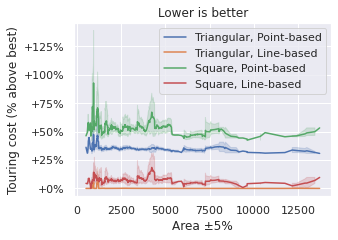

In [11]:
plt.figure(figsize=(5, 3.5))
t = data_area_interval.copy()
t["y"] = (t["relative_cost"] - 1) * 100
sns.lineplot(data=t, x="area", y="y", hue="Grid")
plt.legend(loc="upper right")
plt.ylabel("Touring cost (% above best)")
plt.xlabel("Area ±5%")
plt.title("Lower is better")
plt.tight_layout()
ax = plt.gca()
ax.set_yticklabels([f"+{int(s)}%" for s in ax.get_yticks()])
plt.tight_layout()
plt.savefig("./output/04_touring_cost_area.pdf")
plt.show()

We see that the point based grids are 40-60% more expensive.
Hexagonal, line-based grids yield the best results if well oriented.

## Touring cost in dependency of turn factor

/home/ANONYMOUS_USER/anaconda3/envs/turncost/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


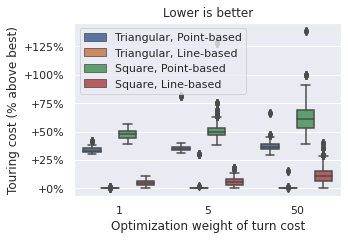

In [12]:
plt.figure(figsize=(5, 3.5))
t = data_area_interval.copy()


def rename(x):
    return x if "Square" in x else x.replace("Hexagonal", "Triangular")


t["Grid"] = t["Grid"].apply(rename)
t["y"] = (t["relative_cost"] - 1) * 100
sns.boxplot(data=t, x="turn_factor", y="y", hue="Grid")
plt.ylabel("Touring cost (% above best)")
plt.xlabel("Optimization weight of turn cost")
plt.title("Lower is better")
plt.legend(loc="upper left")
plt.tight_layout()
ax = plt.gca()
ax.set_yticklabels([f"+{int(s)}%" for s in ax.get_yticks()])
plt.tight_layout()
plt.savefig("./output/04_touring_cost_turn_factor.pdf")
plt.show()

In [13]:
t.groupby(["Grid"])["y"].mean()

Grid
Square, Line-based          7.410750
Square, Point-based        53.508458
Triangular, Line-based      0.203360
Triangular, Point-based    35.457309
Name: y, dtype: float64

For higher turn cost, the square grids perform worse. The hexagonal grids are relatively
stable.

## Coverage area of different grids

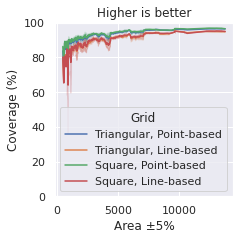

In [14]:
plt.figure(figsize=(3.5, 3.5))
t = data_area_interval.copy()


def rename(x):
    return x if "Square" in x else x.replace("Hexagonal", "Triangular")


t["Grid"] = t["Grid"].apply(rename)
sns.lineplot(data=t, x="area", y="relative_coverage", hue="Grid")
plt.ylim(0, 100)
plt.title("Higher is better")
plt.ylabel("Coverage (%)")
plt.xlabel("Area ±5%")
plt.tight_layout()
plt.savefig("./output/04_coverage_area.pdf")
plt.show()

In [15]:
t_ = t.groupby(["Grid"])["relative_coverage"].mean()
t_["Triangular, Point-based"] / t_["Triangular, Line-based"]

1.0425574429276097

# Other material

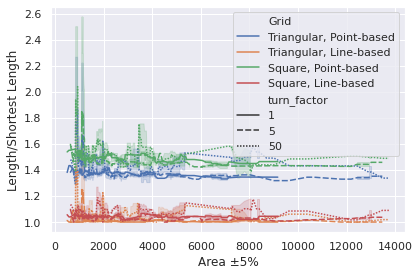

In [16]:
sns.lineplot(
    data=data_area_interval,
    x="area",
    y="relative_length",
    hue="Grid",
    style="turn_factor",
)
plt.legend(loc="upper right")
plt.ylabel("Length/Shortest Length")
plt.xlabel("Area ±5%")
plt.tight_layout()

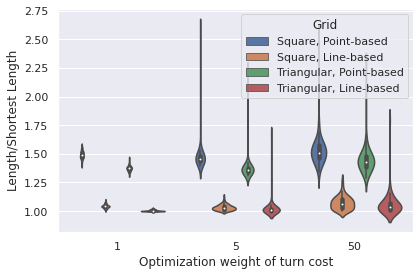

In [17]:
plt.show()
sns.violinplot(data=data, x="turn_factor", y="relative_length", hue="Grid")
plt.ylabel("Length/Shortest Length")
plt.xlabel("Optimization weight of turn cost")
plt.tight_layout()
plt.show()

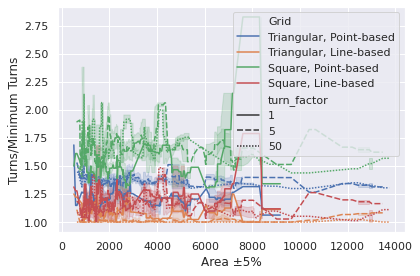

In [18]:
sns.lineplot(
    data=data_area_interval,
    x="area",
    y="relative_turn_sum",
    hue="Grid",
    style="turn_factor",
)
plt.legend(loc="upper right")
plt.ylabel("Turns/Minimum Turns")
plt.xlabel("Area ±5%")
plt.tight_layout()
plt.show()

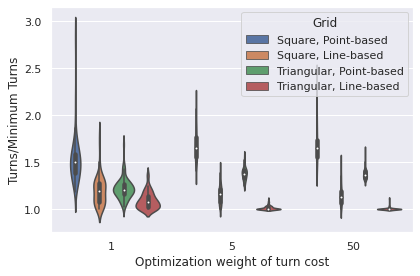

In [19]:
sns.violinplot(data=data, x="turn_factor", y="relative_turn_sum", hue="Grid")
plt.ylabel("Turns/Minimum Turns")
plt.xlabel("Optimization weight of turn cost")
plt.tight_layout()
plt.show()

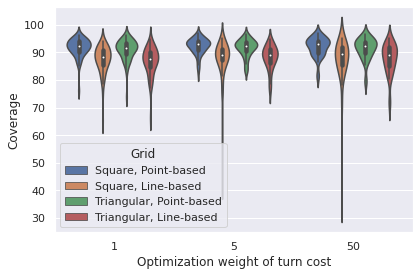

In [20]:
sns.violinplot(data=data, x="turn_factor", y="relative_coverage", hue="Grid")
plt.ylabel("Coverage")
plt.xlabel("Optimization weight of turn cost")
plt.tight_layout()
plt.savefig("./output/04_coverage_turn_factor.pdf")
plt.show()

In [21]:
data.groupby(["Grid", "solver"])["instance"].nunique()

Grid                     solver                                                                                                          
Square, Line-based       RandomSquareAlgorithm(fc=True, pb=False)                                                                            110
                         RotatingSquareAlgorithm(fc=True, pb=False)                                                                           90
Square, Point-based      RandomSquareAlgorithm(fc=True, pb=False)                                                                            115
                         RandomSquareAlgorithm(fc=True, pb=True)                                                                              13
                         RotatingSquareAlgorithm(fc=True, pb=False)                                                                           72
Triangular, Line-based   RandomHexagonAlgorithm(RandomRegularHexagonal(full_coverage=True, point_based=False))                           